# Obtain weekday prototypes
The main objective of this task is to create every weekday prototypes. We want to model two types of days based on the consumption activity of each building:
- **Active** day.
- **Inactive** day.

Thus, for each counter on the database, we'll get 13 day prototypes (6 working days * 2 types of days + 1 inactive day corresponding to Sundays). Moreover, there are 97 different buildings, so we expect to get 13 * 97 prototypical days.

This previouisly mentioned activity will be defined by calculating the mean of Sundays' consumptions for each building (greater than this value plus some margin will indicate an active day; lower or equal than this value plus the margin should be labelled as an inactive day).

#### Directory structure
./<br></br>
notebook/<br></br>
    &emsp;|--- data-preprocessing<br></br>
    &emsp;&emsp;&emsp;&emsp;|--- weekday_prototypes.ipynb<br></br>
out/<br></br>
    &emsp;|--- consumptions_byday/<br></br>

In [1]:
CONS_PATH = 'C:/Users/thmas/OneDrive - Universidad de Castilla-La Mancha/Informática/TFG/out/consumptions_byday/'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
counter_id = 37 # Counter ID example

raw_df = pd.read_pickle(CONS_PATH + 'counter_' + str(counter_id) + '_byDay.zip')
raw_df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
2011-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-07-20,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-07-21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-07-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-07-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-07,17.341348,17.336417,15.108195,13.671267,13.674152,13.431865,12.999662,13.000957,13.004914,12.903182,...,13.242214,15.671428,18.822843,17.765515,17.340447,16.753255,16.913813,17.343652,16.333292,17.337501
2019-04-08,22.000545,56.612431,103.271267,145.560168,169.615259,184.831495,188.087845,184.384277,179.326536,162.088170,...,133.884709,110.235443,44.845136,17.856870,15.672561,16.663765,16.662917,16.611020,16.335881,16.330015
2019-04-09,21.138057,39.147791,74.582498,138.245750,173.078648,185.526796,191.966432,185.262229,191.044624,170.552954,...,146.308853,108.545867,34.622832,29.404141,26.664616,26.651540,26.676399,25.667485,25.675647,26.380449


### Obtaining prototype measures
In order to get the required measures for every day, first we obtain them for sundays, which are supposed to be inactive days. After that, we base the active/inactive result depending on:

- **Inactive days** &rarr; daily consumption mean within [sundays.mean + 2 * sundays.std, +$\infty$)
- **Active days** &rarr; daily consumption mean within [0, sundays.mean + 2 * sundays.std)

We'll store all this prototypical days (every building has 13, as previously discussed) in a pandas DataFrame for later use

In [4]:
def get_threshold(df: pd.DataFrame) -> float:
    df.loc[:, 'mean'] = df.mean(axis=1) # Calculate daily consumption mean
    mean, std = df['mean'].mean(), df['mean'].std()
    
    return mean + 2 * std # Calculate threshold based on sundays

In [5]:
def get_prototype(df: pd.DataFrame, counter_id: int, weekday: int, active: bool) -> pd.DataFrame:
    df = df.drop(columns=['mean'])
    df = df.mean(axis=0) # Calculate hour mean
    df = pd.DataFrame(df).T
    df.insert(0, 'active', active)
    df.insert(0, 'weekday', weekday)
    df.insert(0, 'building_id', counter_id)
    
    return df

In [6]:
clean_df = raw_df.dropna()

sundays = clean_df[clean_df.index.weekday == 6] # Select Sundays
sundays

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
2011-07-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-07-31,4.000000,5.000000,5.000000,4.477907,4.522093,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,6.000000,6.000000,5.000000,5.000000,5.000000,5.000000,4.549364,4.450636
2011-08-07,5.000000,4.000000,4.757190,4.242810,5.000000,4.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,6.000000,6.000000,5.288089,4.711911,5.000000,4.000000,5.000000,4.000000
2011-08-14,4.000000,5.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,6.000000,6.000000,5.394664,4.605336,5.000000,4.000000,5.000000,4.622814
2011-08-21,4.000000,5.000000,5.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.282267,7.717733,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-17,20.426095,20.267664,20.350525,15.157288,13.768649,14.247333,14.002158,16.300770,22.296408,39.204704,...,47.421726,45.682075,46.666810,45.664519,44.070888,25.426454,48.923338,50.249917,50.430376,52.299297
2019-03-17,18.347256,19.353216,17.349670,17.350819,16.921587,16.668886,16.676151,16.105487,16.343177,16.578287,...,18.899629,20.237420,20.345249,19.469408,19.233026,18.809884,26.149804,26.481745,27.354899,37.304983
2019-03-24,18.345021,18.334909,14.436416,18.243903,29.007346,70.262031,59.803273,42.890650,39.162331,28.234029,...,29.361125,23.039972,19.182992,20.343820,17.347966,17.348822,24.337180,24.677328,26.502190,34.831629


In [7]:
threshold = get_threshold(sundays)

prototypes = get_prototype(sundays, counter_id, 6, False) # Get Sundays prototype
prototypes

D:\PythonEnvironments\pytfg\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
D:\PythonEnvironments\pytfg\lib\site-packages\pandas\core\indexing.py:1046: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,building_id,weekday,active,0,1,2,3,4,5,6,...,14,15,16,17,18,19,20,21,22,23
0,37,6,False,18.869982,18.743745,18.064134,17.652458,17.837897,18.231837,18.421455,...,20.588858,20.78845,21.659488,21.895661,20.838044,20.471777,21.837116,22.267339,23.38498,26.0975


In [8]:
for i in range(0, 6):
    df = clean_df[clean_df.index.weekday == i]
    df.loc[:, 'mean'] = df.mean(axis=1) # Calculate daily consumption mean
    
    df_a = df.loc[df['mean'] >= threshold] # Select active days
    prototypes = prototypes.append(get_prototype(df_a, counter_id, i, True))
    
    df_i = df.loc[df['mean'] < threshold] # Select inactive days
    prototypes = prototypes.append(get_prototype(df_i, counter_id, i, False))

prototypes.reset_index(drop=True, inplace=True)
prototypes

,building_id,weekday,active,0,1,2,3,4,5,6,...,14,15,16,17,18,19,20,21,22,23
0,37,6,False,18.869982,18.743745,18.064134,17.652458,17.837897,18.231837,18.421455,...,20.588858,20.788450,21.659488,21.895661,20.838044,20.471777,21.837116,22.267339,23.384980,26.097500
1,37,0,True,38.442016,54.117807,70.707555,105.170246,122.448215,134.559985,143.896980,...,93.735167,61.204952,30.088555,25.323640,23.049783,22.658567,22.646149,23.684181,24.769760,27.091328
2,37,0,False,13.700371,15.601480,17.253953,22.529189,25.985735,26.994702,28.345458,...,25.014501,22.368441,20.700889,16.625012,14.287252,13.604773,13.509729,13.482873,14.128215,14.198038
3,37,1,True,34.986541,52.504606,69.742688,105.497473,127.360898,141.004465,151.586279,...,95.806169,60.794908,30.018418,25.091469,23.124086,23.239496,23.793736,24.275503,25.328295,27.073213
4,37,1,False,12.611784,13.744227,16.538587,21.927839,25.281512,27.179829,28.386919,...,23.597517,21.445700,19.980670,15.915327,13.519934,13.084742,13.330587,13.363022,13.595786,13.495327
5,37,2,True,35.362614,54.308962,72.285829,108.484618,131.452005,145.287151,152.341658,...,96.318243,61.176893,29.568345,24.595802,22.879407,22.447291,22.424299,22.881792,23.526845,25.588522
6,37,2,False,13.611969,14.728953,17.870998,23.203785,27.588266,30.093769,31.514228,...,24.208317,22.435084,20.787102,16.235450,13.621063,13.088778,12.965688,12.954518,12.913191,12.950101
7,37,3,True,34.168656,53.151187,72.033367,110.464380,132.298517,144.293632,149.958114,...,92.616383,59.820604,30.205894,25.168968,23.178151,22.719158,22.675796,23.033368,23.332246,25.273630
8,37,3,False,13.378084,14.534626,16.895025,21.537338,25.471963,27.135341,29.040756,...,22.545443,21.328354,20.810231,16.941868,14.733325,13.840933,13.739658,13.682113,13.690574,14.074583
9,37,4,True,34.027800,53.711607,71.570218,106.955965,126.110710,137.276382,141.765583,...,51.547918,30.618072,27.190976,23.732181,21.757401,21.121641,20.968300,20.861042,20.817891,20.653828


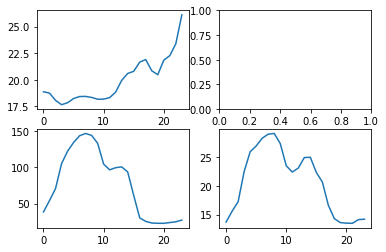

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2)
prototypes.iloc[0, 3:].plot(ax=axes[0,0])
prototypes.iloc[1, 3:].plot(ax=axes[1,0])
prototypes.iloc[2, 3:].plot(ax=axes[1,1])